# Step 1: Import Libraries

### For more details,visit the official documentation: 

## [PyTorch](https://pytorch.org/docs/stable/index.html)


## [Torch.nn](https://pytorch.org/docs/stable/nn.html)



## [Torchvision](https://pytorch.org/vision/stable/index.html)

In [1]:
import matplotlib.pyplot as plt # for visualizing
import os
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

print(torch.__version__)
print(torchvision.__version__)


2.5.1+cu121
0.20.1+cu121


# Step 2: Setting Up Device(GPU-Agnostic code)

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
#check our GPU
!nvidia-smi

Fri Feb 28 14:59:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Step 3: Loading the MNIST Dataset

In [3]:
train_data=torchvision.datasets.MNIST(root='/kaggle/working/',
                                               train=True,
                                               download=True,
                                               transform=torchvision.transforms.ToTensor(),
                                               target_transform=None
                                                 )

test_data=torchvision.datasets.MNIST(root='/kaggle/working/',
                                              train=False,
                                              download=True,
                                              transform=torchvision.transforms.ToTensor(),
                                              target_transform=None)

                                                           

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 59.0MB/s]


Extracting /kaggle/working/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.67MB/s]


Extracting /kaggle/working/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]


Extracting /kaggle/working/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 14.8MB/s]

Extracting /kaggle/working/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw



# Step 4: Creating Dataloaders for Training and Testing

In [4]:
from torch.utils.data import DataLoader #

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=32,
                            shuffle=True )

test_dataloader=DataLoader(dataset=test_data,
                          batch_size=32,
                          shuffle=True)

train_dataloader.dataset,test_dataloader.dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: /kaggle/working/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: /kaggle/working/
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [5]:
import pandas as pd

def create_dataframe (dataloader,dataset_name=str):
    len_data=len(dataloader.dataset)
    num_classes=len(dataloader.dataset.classes)
    #class_name=dataloader.dataset.classes
    sample_image,label=next(iter(dataloader))
    image_shape=sample_image.shape
    batch=len(dataloader)
    label_shape=label.shape
    image_type=sample_image.dtype
    data={'Dataset Name':[dataset_name],
          'Number of images':[len_data],
          'Number of Batch':[batch],
          'Number of classes':[num_classes],
          #'Class names':[class_name],
          'Label shape':[label_shape],
          'Type of images':[image_type],
          'Image shape [N,C,H,W]':[[image_shape]]}
    df=pd.DataFrame(data)
    return df
    

In [8]:
train_df=create_dataframe(train_dataloader,'Train')
test_df=create_dataframe(test_dataloader,'Test')

pd.concat([train_df,test_df])

,Dataset Name,Number of images,Number of Batch,Number of classes,Label shape,Type of images,"Image shape [N,C,H,W]"
0,Train,60000,1875,10,"(32,)",torch.float32,"[(32, 1, 28, 28)]"
0,Test,10000,313,10,"(32,)",torch.float32,"[(32, 1, 28, 28)]"


# Visualizing

In [9]:
test_dataloader.dataset[0][0].shape

torch.Size([1, 28, 28])

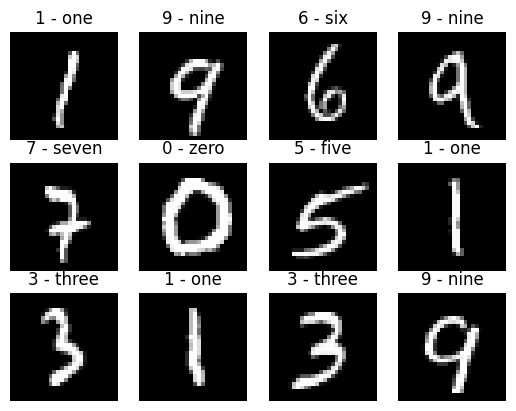

In [10]:
import random
random.seed(42)
test_images_labels=[]

random_inx=random.sample(range(len(test_dataloader)), k=12)  
random_samples=[test_dataloader.dataset[i] for i in random_inx ]
for img,label in random_samples:
    test_images_labels.append((img,label))

for inx,(img,label) in enumerate(test_images_labels):
  
    img=img.permute(1,2,0) # [c,h,w] to [h,w,c]
   
    plt.subplot(3,4,inx+1)
    plt.imshow(img,cmap='gray')
    plt.axis(False)
    title_text=train_dataloader.dataset.classes[label]
    plt.title(title_text)
    
    

In [6]:
class MNISTModelV1(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.conv_block_1=nn.Sequential( # this tow layers are going to be feature extractors.they are trying to learn the patterns that the best represent our data
            torch.nn.Conv2d(in_channels=input_shape,  # Number of channels in the input image
                      out_channels=hidden_units,   #Number of channels produced by the convolution
                      kernel_size=(3,3),  #Size of the convolving kernel
                      stride=1,  # Stride of the convolution. Default: 1
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3,3),
                      stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,2)))
            
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=64,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)))
        #self.match_dimensions=nn.Conv2d(in_channels=512,out_channels=128,kernel_size=(1,1))
            
        
        self.flatten=nn.Flatten()
        
        self.output_shape=output_shape
        self.hidden_units=hidden_units
        self.classifier1=nn.Linear(in_features=1,out_features=hidden_units)
        self.drop=nn.Dropout(p=0.5,inplace=False)
        self.classifier2=nn.Linear(in_features=hidden_units,out_features=hidden_units)
        self.drop2=nn.Dropout(p=0.5,inplace=False)
        self.classifier3=nn.Linear(in_features=hidden_units,out_features=self.output_shape)


    def forward(self,x):
        
        out1=self.conv_block_1(x)
       #print(out1.shape)
      
        out2=self.conv_block_2(out1)
        #print(out2.shape)
        out1=nn.functional.interpolate(out1,size=(out2.shape[2],out2.shape[3]),mode='nearest')
        out2+=out1
       
        x=self.flatten(out2)
        #print(x.shape)
        if self.classifier1.in_features==1:
            in_features=x.shape[1]
            self.classifier1=nn.Linear(in_features,out_features=self.hidden_units).to(x.device)
        x=self.classifier1(x)
        x=self.drop(x)
        
        x=self.classifier2(x)
        x=self.drop2(x)
        x=self.classifier3(x)
       
            

        return x
        
        
            
            

In [9]:
torch.cuda.manual_seed(42)
model=MNISTModelV1(input_shape=1, #color channel
                            hidden_units=64,
                            output_shape=len(train_dataloader.dataset.classes)).to(device)
model

MNISTModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_s

In [10]:
from torchmetrics import Accuracy
from torchmetrics import  ConfusionMatrix
from torchmetrics.classification import MulticlassPrecision


In [11]:


loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)#,momentum=0.9)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
accuracy = Accuracy(task="multiclass", num_classes=len(train_data.classes)).to(device)


In [12]:

def train_step(model:torch.nn.Module,data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device):
    from timeit import default_timer as timer
    torch.cuda.manual_seed(42)
    train_time_start = timer()
    train_loss,train_acc=0,0
    model.train()
    for image, y in data_loader:
        image,y=image.to(device),y.to(device)#.long()
        y_pred = model.forward(image)
        loss= loss_fn(y_pred, y)
        train_loss+=loss
        train_acc+=accuracy_fn(y,y_pred.argmax(dim=1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #scheduler.step()
        
    train_loss /= len(data_loader)
    train_acc/=len(data_loader)
    
    
    train_time_end = timer()                   #Learning Rate :{scheduler.get_last_lr()[0]:.3f}
    
    print(f"\033[92mTrain_loss:{train_loss:.4f}%\n Train_acc:{train_acc:.4f}%\nDevice is on {device}\nTime passed for training:{train_time_end-train_time_start:.2f}s\033[0m")
    return train_loss,train_acc

def test_step(model:torch.nn.Module,dataloader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,accuracy_fn,device:torch.device):
    from timeit import default_timer as timer 
    torch.cuda.manual_seed(42)
    
    model.eval()
    test_loss,test_acc=0,0
    with torch.inference_mode():
        test_time_start = timer()
        for image,y in dataloader:
            image,y=image.to(device),y.to(device)
            test_pred=model(image)
            test_loss+=loss_fn(test_pred,y)
            test_acc+=accuracy_fn(y,test_pred.argmax(dim=1))
            
        test_loss /= len(dataloader)
        test_acc/=len(dataloader)
        
        test_time_end=timer()
        print(f"\033[94mTest loss is-->{test_loss:.4f}%\nTest acc is-->{test_acc:.4f}%\nDevice is on {str(next(model.parameters()).device)}\nTime passed for testing:{test_time_end-test_time_start:.2f}s\033[0m")

        return test_loss,test_acc


In [13]:
from tqdm.auto import tqdm
from timeit import default_timer as timer 

torch.cuda.manual_seed(42)
epochs=7
train_accuracies=[]
train_losses=[]
test_accuracies=[]
test_losses=[]
time_start = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}")
    train_loss,train_acc=train_step(model,train_dataloader,loss_fn,optimizer,accuracy,device=str(next(model.parameters()).device))
    test_loss,test_acc=test_step(model,test_dataloader,loss_fn,accuracy,device=str(next(model.parameters()).device))

    train_losses.append(train_loss.item())
    train_accuracies.append(train_acc.item())
    test_losses.append(test_loss.item())
    test_accuracies.append(test_acc.item())
    print(f"------------------------")
time_end=timer()
print(f'Total time passed :\033[91m{time_end-time_start:.4f}s\033[0m')

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 0
Train_loss:0.4144%
 Train_acc:0.8784%
Device is on cuda:0
Time passed for training:15.04s
Test loss is-->0.0774%
Test acc is-->0.9757%
Device is on cuda:0
Time passed for testing:1.55s
------------------------
Epoch 1
Train_loss:0.1322%
 Train_acc:0.9611%
Device is on cuda:0
Time passed for training:13.44s
Test loss is-->0.0543%
Test acc is-->0.9834%
Device is on cuda:0
Time passed for testing:1.55s
------------------------
Epoch 2
Train_loss:0.0974%
 Train_acc:0.9717%
Device is on cuda:0
Time passed for training:13.59s
Test loss is-->0.0330%
Test acc is-->0.9886%
Device is on cuda:0
Time passed for testing:1.53s
------------------------
Epoch 3
Train_loss:0.0795%
 Train_acc:0.9766%
Device is on cuda:0
Time passed for training:13.44s
Test loss is-->0.0271%
Test acc is-->0.9910%
Device is on cuda:0
Time passed for testing:1.56s
------------------------
Epoch 4
Train_loss:0.0678%
 Train_acc:0.9800%
Device is on cuda:0
Time passed for training:13.63s
Test loss is-->0.0270%
Test ac

In [14]:
model

MNISTModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_s

In [43]:
torch.save({'model_state_dict':model.state_dict(),
            'input_features':model.classifier1.in_features,
            'output_features':model.output_shape},'/kaggle/working/Model.pt')

In [49]:
torch.manual_seed(42)
loaded_model=MNISTModelV1(input_shape=1,
                                   hidden_units=64,
                                   output_shape=len(train_data.classes))


#checkpoint
chekpoint=torch.load('/kaggle/working/Model.pt')
#load in the save state_dict()
loaded_model.classifier1=nn.Linear(in_features=chekpoint['input_features'],
                                    out_features=64).to(device)
#out_features=chekpoint['output_features']

loaded_model.load_state_dict(chekpoint['model_state_dict'])
loaded_model.eval()


<ipython-input-49-d042e3b82be5>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chekpoint=torch.load('/kaggle/working/Model.pt')


MNISTModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_s

In [17]:
import plotly.graph_objects as go

epochs=list(range(1,len(train_accuracies)+1))


train=go.Scatter(x=epochs,
                 y=train_accuracies,
                 mode='lines+markers',
                 name='Train Acc',line=dict(color='royalblue'))



test=go.Scatter(x=epochs,
                 y=test_accuracies,
                 mode='lines+markers',
                 name='Test Acc',line=dict(color='orange'))

figure=go.Figure(data=[train,test])
figure.update_layout(title='Train and Test Accuracy per Epoch',
                    xaxis_title='Epochs',
                    yaxis_title='Accuracy',
                    template='plotly_white')

figure.show()

In [18]:
epochs=list(range(1,len(train_losses)+1))


train=go.Scatter(x=epochs,
                 y=train_losses,
                 mode='lines+markers',
                 name='Train Loss',line=dict(color='red'))



test=go.Scatter(x=epochs,
                 y=test_losses,
                 mode='lines+markers',
                 name='Test Loss',line=dict(color='black'))

figure=go.Figure(data=[train,test])
figure.update_layout(title='Train and Test Loss per Epoch',
                    xaxis_title='Epochs',
                    yaxis_title='Loss',
                    template='plotly_white')

figure.show()

# Evaluate:

In [19]:
import random
#torch.cuda.manual_seed(42)
test_images_labels=[]

random_inx=random.sample(range(len(test_data)), k=9)
random_samples=[test_data[i] for i in random_inx ]
for img,label in random_samples:
    test_images_labels.append((img,label))

model.eval()
with torch.inference_mode():
    for img,label in test_images_labels:
       # print(img.shape)
        img=img.unsqueeze(0).to(device)
        y_logits=model(img)
        y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
      
        if label==y_pred.item():
            print(f'\033[92m True label:{label}, Predicted label:{y_pred.item()}\033[0m')
        else:
            print(f'\033[91m True label:{label}, Predicted label:{y_pred.item()}\033[0m')

 True label:9, Predicted label:9
 True label:0, Predicted label:0
 True label:1, Predicted label:1
 True label:2, Predicted label:2
 True label:8, Predicted label:8
 True label:8, Predicted label:8
 True label:9, Predicted label:9
 True label:6, Predicted label:6
 True label:2, Predicted label:2


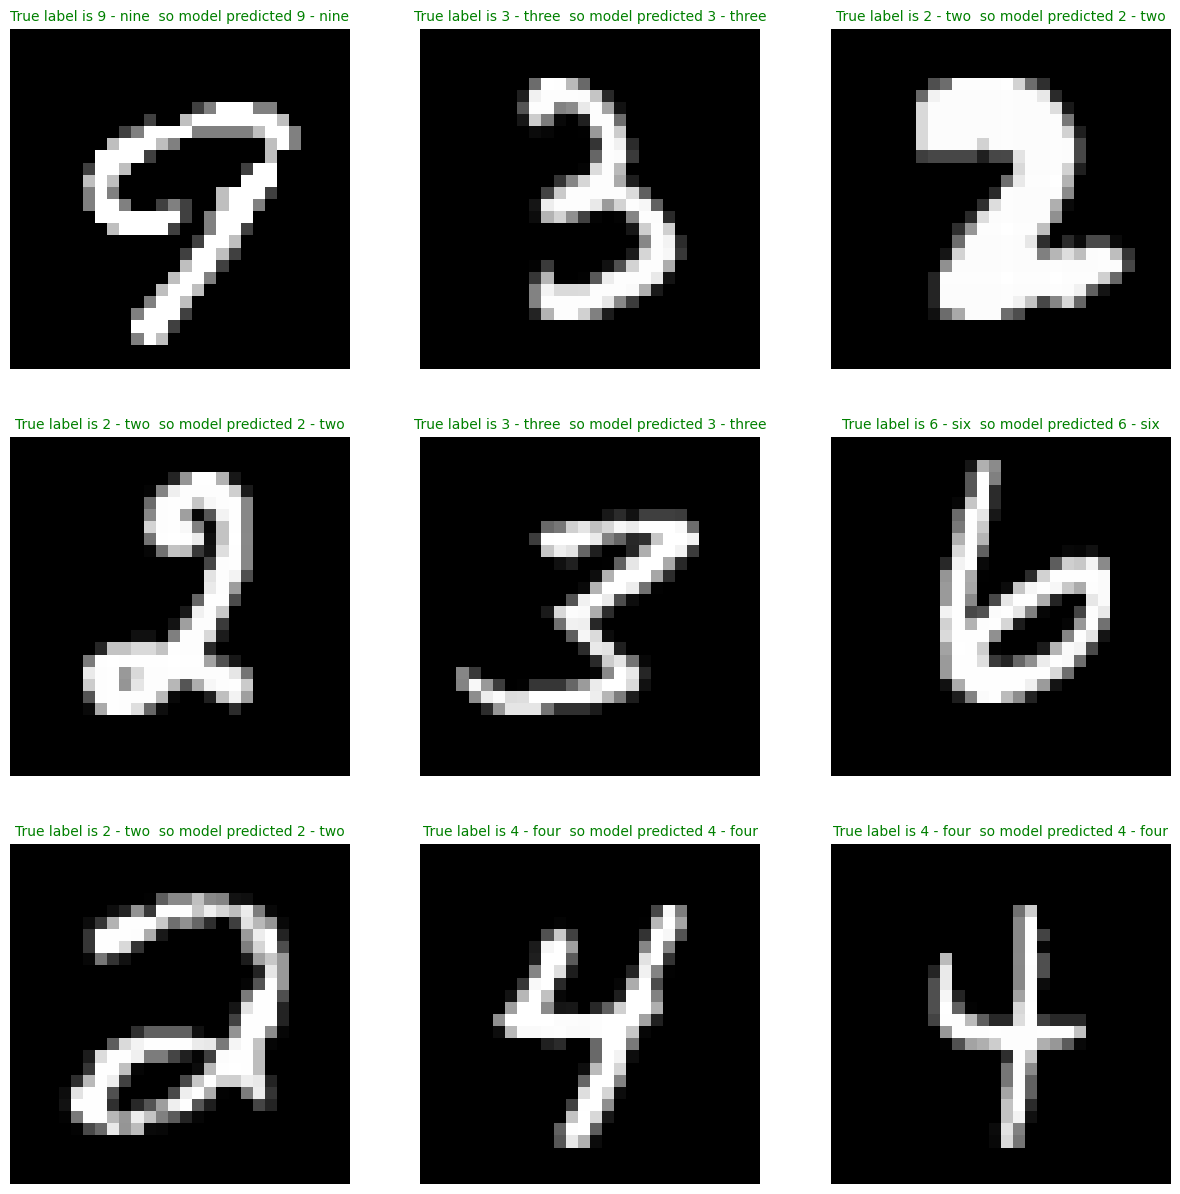

In [20]:
import random
#random.seed(42)
test_images_labels=[]

random_inx=random.sample(range(len(test_data)), k=9)  # or with test_dataloader
random_samples=[test_data[i] for i in random_inx ]
for img,label in random_samples:
    test_images_labels.append((img,label))

y_preds=[]
model.eval()
with torch.inference_mode():
    plt.figure(figsize=(15,15))
    for inx,(img,label) in enumerate(test_images_labels):
        img_model=img.unsqueeze(0).to(device)
        img=img.permute(1,2,0)
        #print(img.shape)
        
        y_logits=model(img_model)
        y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
        y_preds.append(y_pred)
        plt.subplot(3,3,inx+1)
        plt.imshow(img.squeeze(0),cmap='gray')
        plt.axis(False)
        title_true_text=f'True label is {train_data.classes[label]}  so model predicted {train_data.classes[y_pred.item()]}'
        title_false_text=f'Sorry! True label is{train_data.classes[label]} But model predicted {train_data.classes[y_pred.item()]}'
        if label==y_pred.item():
            plt.title(title_true_text,fontsize=10, c="g")
        else:
            plt.title(title_false_text,fontsize=10, c="r")
y_pred_tensor =torch.cat(y_preds,dim=0)    

# ConfusionMatrix:

In [21]:
# 1. Make predictions with trained model
y_preds = []
torch.cuda.manual_seed(42)
model.eval()
with torch.inference_mode():
  for img,label in test_data:
   
      
      image= img.to(device) 
      
     
    # Do the forward pass
      y_logit = model(image.unsqueeze(0))
    # Turn predictions from logits -> prediction probabilities -> predictions labels
      y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    #y_pred=y_logit.argmax(dim=1)
      # Put predictions on CPU for evaluation
      y_preds.append(y_pred.cpu())
print(y_pred.shape)
# Concatenate list of predictions into a tensor
y_pred_tensor =torch.cat(y_preds,dim=0)

torch.Size([1])


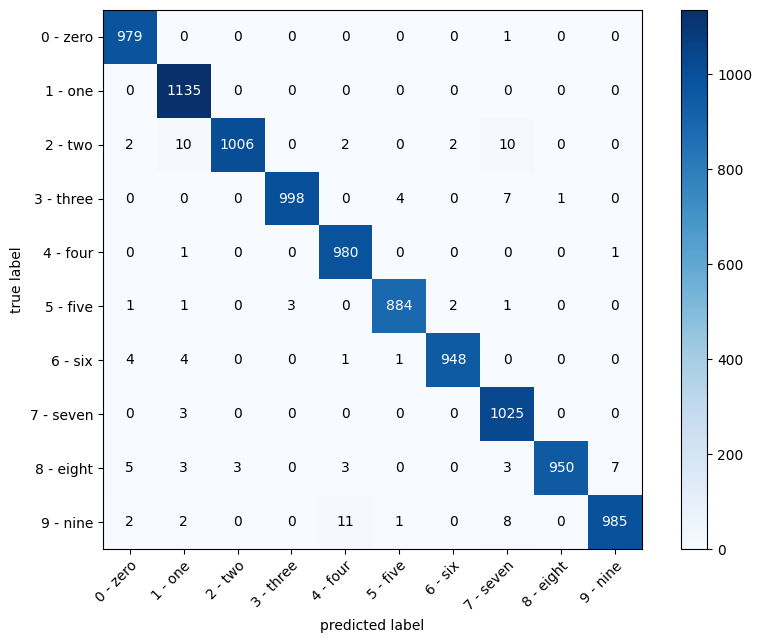

In [22]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(train_data.classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
                                class_names=train_data.classes,colorbar=True, # turn the row and column labels into class names
                              
                                figsize=(10, 7));

# Save model:

In [31]:
torch.save({'model_state_dict':model.state_dict(),
            'input_features':model.classifier1.in_features,
            'output_features':model.output_shape},'model_with_info_path.pt')